In [19]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import euclidean_distances

def create_volume():
    # Create 120x120x120 array with inner 100x100x100 ones
    volume = np.zeros((120, 120, 120))
    volume[10:110, 10:110, 10:110] = 1
    return volume

def create_tube_mask(shape, p1, p2, radius):
    # Create grid of points
    x, y, z = np.meshgrid(np.arange(shape[0]), 
                         np.arange(shape[1]), 
                         np.arange(shape[2]))
    points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
    
    # Convert line segment points to array
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    # Calculate distances from points to line segment
    v = p2 - p1
    w = points - p1.reshape(1, 3)
    c1 = np.dot(w, v)
    c2 = np.dot(v, v)
    b = c1 / c2
    b = np.clip(b, 0, 1)
    pb = p1 + b.reshape(-1, 1) * v
    
    # Calculate distances from points to closest points on line
    distances = np.sqrt(np.sum((points - pb) ** 2, axis=1))
    
    # Create tube mask
    mask = (distances <= radius).reshape(shape)
    return mask

def objective_function(params):
    global volume
    p1 = params[:3]
    p2 = params[3:]
    
    # Create tube mask
    tube = create_tube_mask(volume.shape, p1, p2, 5)
    
    # Calculate intersection volume (negative for minimization)
    return -np.sum(volume * tube)

# Create volume
volume = create_volume()

# Initial guess (diagonal tube)
initial_guess = [10, 10, 10, 109, 109, 109]

# Bounds for optimization
bounds = [(0, 119)] * 6

# Optimize
result = minimize(objective_function, initial_guess, 
                 bounds=bounds, method='SLSQP')

print(f"Best tube parameters: {result.x}")
print(f"Maximum volume: {-result.fun}")

Best tube parameters: [ 10.  10.  10. 109. 109. 109.]
Maximum volume: 13270.0


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import matplotlib.colors as colors

def plot_tube(volume, p1, p2, radius=3):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Calculate tube
    tube = compute_tube_volume(p1, p2, radius, volume.shape)
    intersection = tube * volume
    
    # Plot volume boundaries
    x, y, z = np.where(volume > 0)
    scatter = ax.scatter(x, y, z, alpha=0.1, c='blue', marker='.')
    
    # Plot tube intersection
    x, y, z = np.where(intersection > 0)
    ax.scatter(x, y, z, alpha=0.6, c='red', marker='.')
    
    # Plot endpoints
    ax.scatter([p1[0]], [p1[1]], [p1[2]], color='green', s=100, label='Start')
    ax.scatter([p2[0]], [p2[1]], [p2[2]], color='yellow', s=100, label='End')
    
    # Setup view
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    
    plt.show()

# Example usage:
volume = create_test_volume()
best_params = find_best_tube(volume)
plot_tube(volume, best_params[:3], best_params[3:])


/var/folders/jh/2h78bdyj1qzfbls2j1yfbv9c0000gn/T/ipykernel_1735/4006662982.py:23: RuntimeWarning: invalid value encountered in divide
  v = v / length


KeyboardInterrupt: 

Volume created


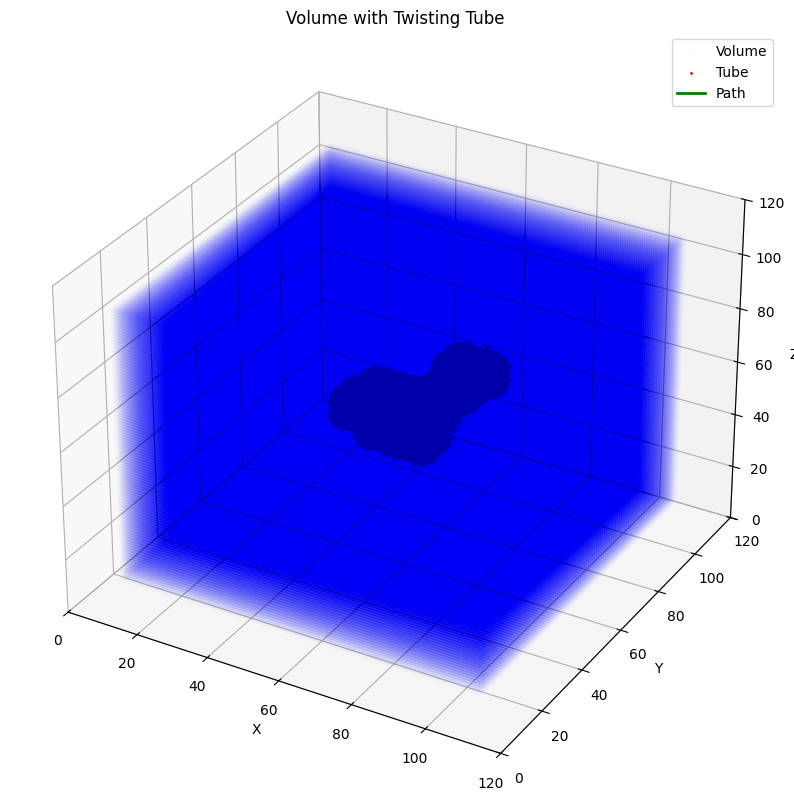

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Volume parameters
volume_size = 120
inner_size = 100
radius = 5
num_turns = 100

# Function to create the volume
def create_volume(volume_size, inner_size):
    volume = np.zeros((volume_size, volume_size, volume_size), dtype=int)
    inner_start = volume_size // 2 - inner_size // 2
    inner_end = volume_size // 2 + inner_size // 2
    volume[inner_start:inner_end, inner_start:inner_end, inner_start:inner_end] = 1
    return volume

# Function to create the tube along a path
def create_tube(volume, path, radius):
    for point in path:
        x, y, z = point
        for i in range(volume_size):
            for j in range(volume_size):
                for k in range(volume_size):
                    if ((i - x)**2 + (j - y)**2 + (k-z)**2) <= radius**2 and volume[i,j,k]==1:
                        volume[i, j, k] = 2
    return volume

# Generate a random path within the inner volume
def generate_path(volume_size, inner_size, num_turns, radius):
    path = []
    center = volume_size // 2
    current_pos = [center, center, center]  # Start at the center
    path.append(current_pos[:])
    directions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)] #6 directions

    for _ in range(num_turns):
        dx, dy, dz = directions[np.random.randint(len(directions))]
        new_pos = [current_pos[0] + dx * radius, current_pos[1] + dy * radius, current_pos[2] + dz * radius]

        # Keep the path within the inner volume
        inner_start = volume_size // 2 - inner_size // 2 + radius
        inner_end = volume_size // 2 + inner_size // 2 - radius

        new_pos[0] = max(inner_start, min(new_pos[0], inner_end))
        new_pos[1] = max(inner_start, min(new_pos[1], inner_end))
        new_pos[2] = max(inner_start, min(new_pos[2], inner_end))
        path.append(new_pos[:])
        current_pos = new_pos
    return path

# Main execution
volume = create_volume(volume_size, inner_size)
path = generate_path(volume_size, inner_size, num_turns, radius)
tube = create_tube(volume, path, radius)
print("Volume created")

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the volume (1s)
x, y, z = np.where(volume == 1)
ax.scatter(x, y, z, c='blue', marker='o', alpha=0.01, label='Volume')

# Plot the tube (2s)
x, y, z = np.where(tube == 2)
ax.scatter(x, y, z, c='red', marker='o', s=1, label='Tube')

# Plot the path
path_x, path_y, path_z = zip(*path)
ax.plot(path_x, path_y, path_z, c='green', linewidth=2, label = "Path")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, volume_size)
ax.set_ylim(0, volume_size)
ax.set_zlim(0, volume_size)
ax.legend()
plt.title("Volume with Twisting Tube")
plt.show()

In [23]:
import sys
sys.path.append("../src")
import pyvista as pv
import numpy as np
import nibabel as nib
import kimimaro
from scipy.spatial import Delaunay


import matplotlib.pyplot as plt

from utils.plotting import plot_skeleton_3d


# Sadly, we cannot plot a 3D delaunay tetrahedralization in pyvista (skill issue)
file = "../data/nnUNet_raw/Dataset042_small_bowel/labelsTs/s0006.nii.gz"
file = nib.load(file)
bowel = np.asarray(file.dataobj)
print(np.unique(bowel))

skels = kimimaro.skeletonize(
    bowel,
    teasar_params={
        "scale": 3,
        "const": 5,
        "pdrf_scale": 10000,
        "pdrf_exponent": 4,
        "soma_acceptance_threshold": 3500,  # physical units
        # "soma_detection_threshold": 750,  # physical units
        # "soma_invalidation_const": 300,  # physical units
        # "soma_invalidation_scale": 2,
    },
    anisotropy=(1, 1, 1),
    dust_threshold=5,
    fix_branching=True,
    progress=True,
    parallel_chunk_size=100, # for the progress bar
)

skeleton = skels[1]
print(skeleton.cable_length())
# skeleton.viewer()

# Idea: Discretize the voxel space in coordinates

[0 1]


Skeletonizing Labels: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

1353.1921


In [7]:
delaunay = Delaunay(np.asarray(bowel.nonzero()).T)
print(len(delaunay.simplices))

np.concatenate([np.full(delaunay.simplices.shape[0],4).reshape(-1,1), delaunay.simplices], axis=1)

1504395


array([[     4,   1813, 143789,  35683,   1814],
       [     4,   1813,   9804,  35683,   1814],
       [     4, 179710, 170308, 168291, 179703],
       ...,
       [     4, 154823, 152747, 152793, 152746],
       [     4, 154823, 152747, 154777, 152746],
       [     4, 154823, 154778, 152747, 154777]])

In [37]:
from meshlib import mrmeshpy as mm
from meshlib import mrmeshnumpy as mn
from meshlib import mrviewerpy as mv
from skimage import measure
import meshlib
import vtk
import os


mesh = mn.simpleVolumeFrom3Darray(bowel.astype(float))


#convert SimpleVolume to FloatGrid data
floatGrid = mm.simpleVolumeToDenseGrid(mesh)
grid_to_mesh_settings = mm.GridToMeshSettings()
grid_to_mesh_settings.voxelSize = mm.Vector3f(1.,1.,1.)
mesh = mm.gridToMesh(floatGrid, settings=grid_to_mesh_settings)
mesh.volume()
# mv.launch() # a window will be opened
# mv.addMeshToScene(mesh, "Mesh 1") # show initial mesh
# mv.Viewer().preciseFitDataViewport() # fit viewer to the mesh
# mv.selectByName("Mesh 1")
 
# mv.Viewer().preciseFitDataViewport() # fit viewer to the mesh
# mv.Viewer().showSceneTree(True) # enables Scene Tree in Viewer window
# # user can manipulate with viewer window while this python is on pause
# os.system("pause")
 
# # remove all objects from scene
# mv.clearScene()
 
# # close viewer window nicely
# mv.Viewer().shutdown()
# # os.system("pause")


0.0

[30/01/25 17:06:11.949] [critical] Crash signal: 15
[30/01/25 17:06:11.967] [info] Crash stacktrace:
 0# (anonymous namespace)::crashSignalHandler(int) in /Users/Matey/project/segmentor/.venv/lib/python3.12/site-packages/meshlib/.dylibs/libMRMesh.dylib
 1# _sigtramp in /usr/lib/system/libsystem_platform.dylib
 2# kevent in /usr/lib/system/libsystem_kernel.dylib
 3# select_kqueue_control_impl in /Users/Matey/miniforge3/lib/python3.12/lib-dynload/select.cpython-312-darwin.so
 4# _PyEval_EvalFrameDefault in /Users/Matey/miniforge3/bin/python3.12
 5# PyEval_EvalCode in /Users/Matey/miniforge3/bin/python3.12
 6# builtin_exec in /Users/Matey/miniforge3/bin/python3.12
 7# cfunction_vectorcall_FASTCALL_KEYWORDS in /Users/Matey/miniforge3/bin/python3.12
 8# _PyEval_EvalFrameDefault in /Users/Matey/miniforge3/bin/python3.12
 9# pymain_run_module in /Users/Matey/miniforge3/bin/python3.12
10# Py_RunMain in /Users/Matey/miniforge3/bin/python3.12
11# pymain_main in /Users/Matey/miniforge3/bin/python

: 

In [26]:
skely_delauney = Delaunay(skeleton.vertices)

skeleton_3d = pv.PolyData(skely_delauney.points, strips=np.concatenate((np.full(skely_delauney.simplices.shape[0],4).reshape(-1,1), skely_delauney.simplices), axis=1).flatten())

skeleton_3d.plot(opacity=0.3, show_edges=True)

Widget(value='<iframe src="http://localhost:51230/index.html?ui=P_0x149a3d730_21&reconnect=auto" class="pyvist…

In [10]:
(skely_delauney.simplices).shape
# Low-energy model that can find the parameters of the twist and turns, the hyperparameters of the tube, and maybe some neural network that can predict the tube from the volume
# Generate a Voronoi-like diagram which might find a boundary between the tube and the volume
# Superpixel/super-voxel-based segmentation
# If we are going into RL, we need to have a reward function that can be examined at each step of the optimization; Martin expresses the opinion that RL should be the last step for refining the model.  

(31252, 4)

In [25]:
# additional_points = skeleton.vertices[skely_delauney.simplices].mean(axis=1).astype(int)
# print(len(additional_points))

# _additional_points = {}
# _ignore = {}
# for i, point in enumerate(additional_points):
#     tup = tuple(point)
#     if tup in _additional_points:
#         _ignore[i] = i
#     else:
#         _additional_points[i]=tup
# additional_points = np.array(list(_additional_points.values()))

# skeleton_2 = skeleton.clone()
# skeleton_2.vertices = np.concatenate((skeleton.vertices, additional_points), axis=0)

# skely_delauney.simplices 

# additional_points_idx = np.arange(len(skeleton.vertices), len(skeleton.vertices) + len(additional_points)).reshape(-1,1)

# print(skeleton_2.edges.shape)
# additional_edges = []
# simplices = skely_delauney.simplices[~np.isin(np.arange(len(skely_delauney.simplices)), _ignore)]
# for i in range(simplices.shape[1]):
#     additional_edges.append(np.concatenate((simplices[:, i].reshape(-1,1), additional_points_idx), axis=1))
# additional_edges = np.concatenate(additional_edges, axis=0)

# skeleton_2.edges = np.concatenate((skeleton.edges, additional_edges + len(skeleton.vertices)), axis=0)
# skeleton_2.radii = np.concatenate((skeleton.radii, np.full(len(additional_edges), 1)), axis=0)
# print(len(skeleton_2.edges))

plotter = pv.Plotter()
# plotter.add_mesh(skeleton_2.vertices, color='red')
# plotter.add_mesh(skeleton.vertices, color='blue')
# plotter.show()


def plot_skeleton_3d(skeleton, volume = None):
    """Plot a 3D skeleton with pyvista

    Parameters
    ----------
    skeleton : cloudvolume.Skeleton
        The skeleton to plot. Should contain the vertices, edges and radii
    volume : np.ndarray, optional
        The volume segmentation mask to plot. Default is None.
    """
    plotter = pv.Plotter()

    skeleton_3d = pv.PolyData(
        skeleton.vertices,
        lines=np.concatenate((np.full(skeleton.edges.shape[0], 2).reshape(-1, 1), skeleton.edges), axis=1),
    )

    if hasattr(skeleton, "radii"):
        # Not sure why we need to remove one element, but for some reason the polydata is one element less.
        skeleton_3d.cell_data["width"] = skeleton.radii[1:]

    plotter.add_mesh(skeleton_3d, show_edges=True, line_width=5, scalars="width")

    if volume is not None:
        plotter.add_volume(volume * 20, cmap="viridis", specular=0.5, specular_power=15)

    plotter.view_xz()
    plotter.show()

plot_skeleton_3d(skeleton, bowel)

Widget(value='<iframe src="http://localhost:51230/index.html?ui=P_0x16ddcd220_20&reconnect=auto" class="pyvist…

In [ ]:
skels[1]??
# Algorithm for post-processing of the skeleton
# 1. Add weak edges to the outside points of the skeleton (using Delaunay points)
# 1.5. Add weak edges with a neighbourhood of ~3. 
# 2. Split the nodes with radius > T into two nodes (iteratively, until all nodes have radius < T)
# 3. Add connections for the split nodes (from beginning to end, e.g. 1-2-3 -> 1-2, 2-3, 1-4, 4-3)

Type:        Skeleton
String form: Skeleton(segid=1, vertices=(shape=6804, float32), edges=(shape=6803, uint32), radius=(6804, float32), vertex_types=(6804, uint8), space='voxel' transform=[[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]])
File:        ~/project/segmentor/.venv/lib/python3.12/site-packages/cloudvolume/skeleton.py
Source:     
class Skeleton(object):
  """
  A stick figure representation of a 3D object. 

  vertices: [[x,y,z], ...] float32
  edges: [[v1,v2], ...] uint32
  radii: [r1,r2,...] float32 distance from vertex to nearest boudary
  vertex_types: [t1,t2,...] uint8 SWC vertex types
  segid: numerical ID
  transform: 3x4 scaling and translation matrix (ie homogenous coordinates) 
    that represents the transformaton from voxel to physical coordinates.
    
    Example Identity Matrix:
    [
      [1, 0, 0, 0],
      [0, 1, 0, 0],
      [0, 0, 1, 0]
    ]

  space: 'voxel', 'physical', or user choice (but other choices 
    make .physical_space() a

In [66]:
import vtk
import pyvista as pv
import nibabel as nib


def nii_2_mesh(filename_nii, filename_stl, label):
    """
    Read a nifti file including a binary map of a segmented organ with label id = label.
    Convert it to a smoothed mesh of type stl.

    filename_nii     : Input nifti binary map
    filename_stl     : Output mesh name in stl format
    label            : segmented label id
    
    Courtesy of: https://github.com/MahsaShk/MeshProcessing/blob/master/nii_2_mesh_conversion.py
    """

    # read the file
    reader = vtk.vtkNIFTIImageReader()
    reader.SetFileName(filename_nii)
    reader.Update()

    # apply marching cube surface generation
    surf = vtk.vtkDiscreteMarchingCubes()
    surf.SetInputConnection(reader.GetOutputPort())
    surf.SetValue(0, label)  # use surf.GenerateValues function if more than one contour is available in the file
    surf.Update()

    # smoothing the mesh
    smoother = vtk.vtkWindowedSincPolyDataFilter()
    if vtk.VTK_MAJOR_VERSION <= 5:
        smoother.SetInput(surf.GetOutput())
    else:
        smoother.SetInputConnection(surf.GetOutputPort())
    smoother.SetNumberOfIterations(30)
    smoother.NonManifoldSmoothingOn()
    smoother.NormalizeCoordinatesOn()  # The positions can be translated and scaled such that they fit within a range of [-1, 1] prior to the smoothing computation
    smoother.GenerateErrorScalarsOn()
    smoother.Update()

    # save the output
    writer = vtk.vtkSTLWriter()
    writer.SetInputConnection(smoother.GetOutputPort())
    writer.SetFileTypeToASCII()
    writer.SetFileName(filename_stl)
    writer.Write()


filename_nii = "../data/nnUNet_raw/Dataset042_small_bowel/labelsTs/s0006.nii.gz"
filename_stl = "01.stl"
label = 1
# nii_2_mesh(filename_nii, filename_stl, label)
bowel = np.asarray(nib.load(filename_nii).dataobj)

filename = "../data/nnUNet_raw/Dataset042_small_bowel/imagesTr/s0006_0000.nii.gz"
# nii = pv.read(filename)
nii = np.array(nib.load(filename).dataobj)
nii = np.where((nii > np.quantile(nii, 0.0005)) & (nii < (np.quantile(nii, 0.9995))), nii, 0)
window_c, window_w = 50, 400
nii = np.where((nii >= window_c - window_w/2) & (nii <= window_c + window_w/2), nii, 0)
# nii = nii / np.linalg.norm(nii, axis=-1, keepdims=True)

pv.plot(nii, opacity='sigmoid')

def save_nifti(data, filename, other = None):
    if other is None:
        other = nib.load(filename)
    else:
        other = nib.load(other)
    new_image = nib.Nifti1Image(data, other.affine, other.header)
    nib.save(new_image, filename)
    
# save_nifti(nii, "test.nii.gz", filename)

Widget(value='<iframe src="http://localhost:63528/index.html?ui=P_0x142578920_1&reconnect=auto" class="pyvista…

In [ ]:
import tetgen
import pyvista as pv

mesh = pv.read(filename_stl)
tet = tetgen.TetGen(mesh)
print(tet.v.shape, tet.f.shape)
nodes, elems = tet.tetrahedralize(order=1, mindihedral=20, minratio=1.5) # TODO: How to make more coarse?
grid = tet.grid
print(grid.points.shape)
grid.plot(show_edges=True, opacity=0.8)

(77946, 3) (155920, 3)
(177946, 3)


Widget(value='<iframe src="http://localhost:63528/index.html?ui=P_0x14bd8b410_3&reconnect=auto" class="pyvista…

In [ ]:
# get cell centroids
cells = grid.cells.reshape(-1, 5)[:, 1:]
cell_center = grid.points[cells].mean(1)

# extract cells below the 0 xy plane
mask = cell_center[:, 2] < 110
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(mesh, 'r', 'wireframe')
plotter.add_legend([[' Input Mesh ', 'r'],
                    [' Tessellated Mesh ', 'black']])
plotter.show()


Widget(value='<iframe src="http://localhost:63528/index.html?ui=P_0x14fb0daf0_4&reconnect=auto" class="pyvista…

: 

In [68]:
pv.plot(edges)

Widget(value='<iframe src="http://localhost:63528/index.html?ui=P_0x14ca10770_2&reconnect=auto" class="pyvista…

In [60]:
from skimage.segmentation import slic
from skimage.filters import meijering
from skimage.graph import RAG
from skimage.morphology import binary_dilation
import pickle
import os

# ############################
# Generate supervoxels
# ----------------------------
# We detect the walls by ridge detection (valley detection to be exact). The Meijering filter is used in this paper.
# ############################

if "edges" not in locals():
    if os.path.exists("edges.pkl"):
        with open("edges.pkl", "rb") as f:
            edges = pickle.load(f)
            np.save("edges.npy", edges)
    else:
        edges = meijering(nii, black_ridges=False)
        with open("edges.pkl", "wb") as f:
            pickle.dump(edges.astype(np.float32), f)

# ############################
# Compute segments
# ----------------------------
# We use the SLIC algorithm to segment the image into superpixels. The compactness parameter is set to 0.001 to create a large number of segments. The start_label parameter is set to 1 to avoid zero-valued labels. The sigma parameter is set to 0 to avoid smoothing the image.
# TODO: Check if using SLIC0 is correct.
# ############################
if "segments" not in locals():
    if os.path.exists("segments.pkl"):
        with open("segments.pkl", "rb") as f:
            segments = pickle.load(f)
    else:
        segments = slic(
            edges, n_segments=400, compactness=0.001, start_label=1, channel_axis=None, sigma=0, slic_zero=True
        )
        with open("segments.pkl", "wb") as f:
            pickle.dump(segments.astype(np.uint16), f)


# ############################
# Generate the edges
# ----------------------------
# An edge e_{i,j} is created between two adjacent supervoxels s_i, s_j and the edge cost C_{i,j} is defined as the average value in the wall detection map along their boundary. Thus, the cost between a supervoxel within the lumen but attached to the wall and a neighboring supervoxel on the wall would be high while that of adjacent supervoxels inside the lumen would be zero.
# ############################
# Define the graph edges
if "rag" not in locals():
    if os.path.exists("rag.pkl"):
        with open("rag.pkl", "rb") as f:
            rag = pickle.load(f)
    else:
        rag = RAG(segments)
        # Give the edges a weight, using the edges array, i.e. the average value in the wall detection map along their boundary

        # Intermediate step where we pre-compute dilations for all nodes:
        dilation = {node: binary_dilation(segments == node) for node in rag}

        for u, v in rag.edges:
            if "cost" in rag[u][v]:
                continue
            val = np.mean(edges[dilation[u] & dilation[v]])
            rag[u][v]["cost"] = val
            rag[v][u]["cost"] = val

        with open("rag.pkl", "wb") as f:
            pickle.dump(rag, f)

        # Free up memory
        del dilation

In [ ]:
edges

# The potential issue of 

# What you want to model is the flow of two cells: and the flow of the two cells is defined by the surface of the cells. The flow goes orthogonal to the surface. Therefore you should go into the direction of the path and not orthogonal to the path.
# We want to quantify the cost of crossing a wall, not just the cost of all pixels even the ones which don't relate.


In [ ]:
import networkx as nx
import numpy as np


# if 'rag' in locals():
#     with open("rag.pkl", "wb") as f:
#         pickle.dump(rag, f)
# else:
#     with open("rag.pkl", "rb") as f:
#         rag = pickle.load(f)


# ############################
# Graph Simplification
# ----------------------------
# Simplify the graph by only retaining the nodes which are present in the segmentation. NOTE: Why don't we do this from the get go?
# ############################
# Remove the nodes which are not in the segmentation
mask = np.unique(np.where(bowel, segments, 0))
rag.remove_nodes_from(mask)
start_node = 7
end_node = 300
# Add a final node with infinite cost to all other nodes
dummy_node = np.iinfo(np.int64).max
rag.add_node(dummy_node)
for node in rag.nodes:
    if node != dummy_node:
        rag.add_edge(node, dummy_node, cost=np.inf)

NameError: name 'segments' is not defined

In [65]:
edges = meijering(nii, sigmas=[1], black_ridges=True)